### Python script with Weighted Hamming Kernel 


- A variation of the Hamming kernel where different features (members) have different importance.
- **Kernel function:**

$
k(x, x') = \exp \left( - \sum_i w_i \mathbf{1} (x_i \neq x'_i) \right)
$

where $ w_i $ is a weight indicating the relative importance of design variable $ i $.

### Example Use:
Some truss members might be more critical than others. The weighted Hamming kernel allows prioritizing important members in the optimization process.


In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor

def weighted_hamming_kernel(X, Y=None, weights=None):
    """
    Weighted Hamming Kernel for binary variables.
    
    Parameters:
        X: ndarray (n_samples_X, n_features) - Binary input data.
        Y: ndarray (n_samples_Y, n_features) - Binary input data (optional).
        weights: ndarray (n_features,) - Feature weights (optional).
    
    Returns:
        Kernel matrix K (n_samples_X, n_samples_Y)
    """
    X = np.atleast_2d(X)
    Y = X if Y is None else np.atleast_2d(Y)

    if weights is None:
        weights = np.ones(X.shape[1])  # Default: equal weights

    # Compute weighted Hamming distances
    dists = np.sum(weights * (X[:, None, :] != Y[None, :, :]), axis=2)

    # Apply exponential transformation to obtain kernel matrix
    return np.exp(-dists)

# Example: Binary truss topology optimization

# Binary design space (each row represents a binary vector for truss topology)
X_train = np.array([
    [1, 0, 1, 1, 0], 
    [0, 1, 1, 0, 1], 
    [1, 1, 0, 1, 0],
    [0, 0, 1, 1, 1]
])

# Simulated performance scores (e.g., compliance or weight minimization objective)
y_train = np.array([0.8, 0.6, 0.9, 0.7])  # Lower is better

# Define weights for the kernel (important members have higher weight)
weights = np.array([1.5, 1.0, 0.5, 1.2, 0.8])

# Create a Gaussian Process model
gp = GaussianProcessRegressor(alpha=0.01, normalize_y=True)

# Custom kernel function for GPR
def custom_kernel(X, Y=None):
    return weighted_hamming_kernel(X, Y, weights=weights)

# Fit GP model using manually computed kernel matrix
gp.fit(X_train, y_train)

# Define acquisition function (Expected Improvement)
def acquisition(X_new, gp, X_train, y_train):
    """Expected Improvement Acquisition Function"""
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = np.maximum(sigma, 1e-6)  # Numerical stability
    best_y = np.min(y_train)
    improvement = best_y - mu
    return improvement * (improvement > 0)  # EI only for improving points

# Bayesian Optimization loop: Find best topology
def optimize_topology(X_train, y_train, gp, num_iters=1000):
    best_topology = None
    best_value = float('inf')

    for _ in range(num_iters):
        X_candidates = np.random.randint(0, 2, (10, 5))  # Generate random binary candidates
        EI_values = acquisition(X_candidates, gp, X_train, y_train)
        
        best_idx = np.argmax(EI_values)
        candidate = X_candidates[best_idx]

        # Evaluate candidate (simulated performance score)
        candidate_score = np.random.uniform(0.5, 1.0)

        if candidate_score < best_value:
            best_topology, best_value = candidate, candidate_score

        # Update dataset
        X_train = np.vstack([X_train, candidate])
        y_train = np.append(y_train, candidate_score)

        # Re-train GP
        gp.fit(X_train, y_train)

    return best_topology, best_value

# Run optimization
best_truss, best_score = optimize_topology(X_train, y_train, gp)
print("Best Truss Design:", best_truss)
print("Best Score:", best_score)

Best Truss Design: [0 1 0 0 0]
Best Score: 0.500660013179572


### Python Script with Tanimoto Kernel

- Used for binary and discrete data.
- Measures the similarity of two binary vectors using the **Tanimoto coefficient**:

$
k(x, x') = \frac{x \cdot x'}{||x||^2 + ||x'||^2 - x \cdot x'}
$

This ensures that if two designs share more members, they are considered more similar.

### Example Use:
Comparing different truss topologies by the proportion of common structural members.

In [5]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor

def tanimoto_kernel(X, Y=None):
    """
    Tanimoto Kernel for binary variables.
    
    Parameters:
        X: ndarray (n_samples_X, n_features) - Binary input data.
        Y: ndarray (n_samples_Y, n_features) - Binary input data (optional).
    
    Returns:
        Kernel matrix K (n_samples_X, n_samples_Y)
    """
    X = np.atleast_2d(X)
    Y = X if Y is None else np.atleast_2d(Y)

    # Compute dot product (X · Y)
    XY = np.dot(X, Y.T)

    # Compute squared norms ||X||^2 and ||Y||^2
    X_norm = np.sum(X**2, axis=1).reshape(-1, 1)
    Y_norm = np.sum(Y**2, axis=1).reshape(1, -1)

    # Compute Tanimoto Kernel
    K = XY / (X_norm + Y_norm - XY + 1e-6)  # Small epsilon for numerical stability

    return K

# Example: Binary truss topology optimization

# Binary design space (each row represents a binary vector for truss topology)
X_train = np.array([
    [1, 0, 1, 1, 0], 
    [0, 1, 1, 0, 1], 
    [1, 1, 0, 1, 0],
    [0, 0, 1, 1, 1]
])

# Simulated performance scores (e.g., compliance or weight minimization objective)
y_train = np.array([0.8, 0.6, 0.9, 0.7])  # Lower is better

# Create a Gaussian Process model
gp = GaussianProcessRegressor(alpha=0.01, normalize_y=True)

# Custom kernel function for GPR
def custom_kernel(X, Y=None):
    return tanimoto_kernel(X, Y)

# Fit GP model using manually computed kernel matrix
gp.fit(X_train, y_train)

# Define acquisition function (Expected Improvement)
def acquisition(X_new, gp, X_train, y_train):
    """Expected Improvement Acquisition Function"""
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = np.maximum(sigma, 1e-6)  # Numerical stability
    best_y = np.min(y_train)
    improvement = best_y - mu
    return improvement * (improvement > 0)  # EI only for improving points

# Bayesian Optimization loop: Find best topology
def optimize_topology(X_train, y_train, gp, num_iters=1000):
    best_topology = None
    best_value = float('inf')

    for _ in range(num_iters):
        X_candidates = np.random.randint(0, 2, (10, 5))  # Generate random binary candidates
        EI_values = acquisition(X_candidates, gp, X_train, y_train)
        
        best_idx = np.argmax(EI_values)
        candidate = X_candidates[best_idx]

        # Evaluate candidate (simulated performance score)
        candidate_score = np.random.uniform(0.5, 1.0)

        if candidate_score < best_value:
            best_topology, best_value = candidate, candidate_score

        # Update dataset
        X_train = np.vstack([X_train, candidate])
        y_train = np.append(y_train, candidate_score)

        # Re-train GP
        gp.fit(X_train, y_train)

    return best_topology, best_value

# Run optimization
best_truss, best_score = optimize_topology(X_train, y_train, gp)
print("Best Truss Design:", best_truss)
print("Best Score:", best_score)

Best Truss Design: [0 0 1 0 1]
Best Score: 0.5000415384724269


In [2]:
import numpy as np
from hyperopt import hp, fmin, tpe, Trials

# Number of structural members
NUM_MEMBERS = 10

# Define the search space (binary variables for topology selection)
search_space = [hp.choice(f'beam_{i}', [0, 1]) for i in range(NUM_MEMBERS)]

# Simulated Structural Analysis Function (FEA proxy)
def evaluate_topology(config):
    """
    Evaluates the weight and structural efficiency of a gridshell topology.
    The function returns an objective value where lower is better.
    """
    weight_per_member = 10  # Assume each member has a weight of 10 kg
    selected_members = np.array(config)  # Convert list to numpy array
    
    # Calculate total weight
    total_weight = np.sum(selected_members) * weight_per_member

    # Simulated "stiffness penalty" (more members = better stiffness)
    stiffness_penalty = np.sum(selected_members)  # More members → better stability

    # Objective: Minimize weight, but penalize for lack of stiffness
    if stiffness_penalty == 0:
        return 1000  # High penalty for empty structures
    
    performance_metric = total_weight - 5 * stiffness_penalty  # Balance weight & stiffness
    return performance_metric  # Lower is better

# Run Bayesian Optimization (TPE)
trials = Trials()
best_topology = fmin(
    fn=evaluate_topology,  # Objective function
    space=search_space,  # Search space
    algo=tpe.suggest,  # Use TPE optimizer
    max_evals=50,  # Number of iterations
    trials=trials  # Store results
)

# Decode best topology (convert indices to binary)
best_structure = [best_topology[f'beam_{i}'] for i in range(NUM_MEMBERS)]

# Print results
print("\nBest Topology (Binary Vector):", best_structure)
print("Total Weight (kg):", np.sum(best_structure) * 10)

100%|██████████| 50/50 [00:00<00:00, 105.50trial/s, best loss: 5.0] 

Best Topology (Binary Vector): [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]
Total Weight (kg): 10


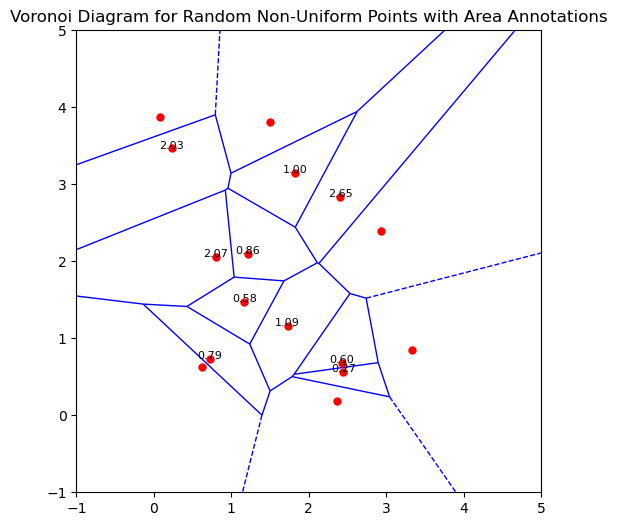

Voronoi Cell Areas:
Region 5: 0.2744
Region 7: 0.5970
Region 9: 0.7929
Region 10: 0.8625
Region 11: 0.5778
Region 12: 2.0734
Region 13: 2.6491
Region 14: 0.9988
Region 15: 1.0894
Region 16: 2.0314


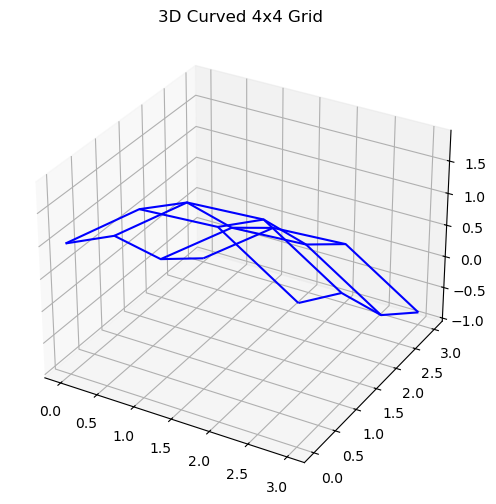

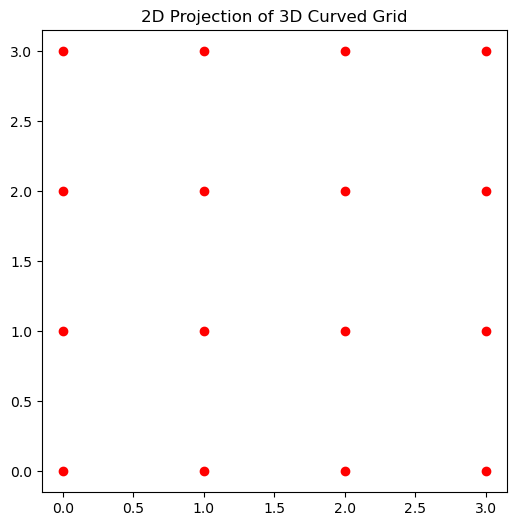

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon
from mpl_toolkits.mplot3d import Axes3D

# Generate random non-uniform points within a 4x4 bounding box
num_points = 16  # Same as the 4x4 grid (for comparison)
np.random.seed(42)  # For reproducibility
points = np.random.uniform(0, 4, size=(num_points, 2))  # Random (x, y) within [0,4]x[0,4]

# Compute Voronoi diagram
vor = Voronoi(points)

# Define a bounding box (to clip infinite regions)
bbox = Polygon([(-1, -1), (-1, 5), (5, 5), (5, -1)])

# Function to compute Voronoi cell area
def voronoi_cell_area(region):
    if -1 in region:  # Ignore infinite regions
        return None
    poly = Polygon([vor.vertices[i] for i in region])
    clipped_poly = poly.intersection(bbox)  # Clip to bounding box
    return clipped_poly.area

# Compute areas of Voronoi cells
region_areas = {}
for i, region in enumerate(vor.regions):
    if len(region) > 0 and -1 not in region:
        area = voronoi_cell_area(region)
        if area is not None:
            region_areas[i] = area

# Plot the Voronoi diagram
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue')

# Overlay random points
ax.plot(points[:, 0], points[:, 1], 'ro', markersize=5)

# Display areas on the plot
for i, region in enumerate(vor.point_region):
    if region in region_areas:
        ax.text(points[i, 0], points[i, 1], f"{region_areas[region]:.2f}", 
                fontsize=8, ha='center', color='black')

ax.set_xlim(-1, 5)
ax.set_ylim(-1, 5)
ax.set_title("Voronoi Diagram for Random Non-Uniform Points with Area Annotations")
plt.show()

# Print computed areas
print("Voronoi Cell Areas:")
for k, v in region_areas.items():
    print(f"Region {k}: {v:.4f}")

# 3D Grid with Curvature
x = np.linspace(0, 3, 4)
y = np.linspace(0, 3, 4)
x, y = np.meshgrid(x, y)
z = np.sin(x) + np.cos(y)  # Example curvature function

# 3D Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, color='b')
ax.set_title("3D Curved 4x4 Grid")
plt.show()

# 2D Projection (XY-plane)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x, y, color='r')
ax.set_title("2D Projection of 3D Curved Grid")
plt.show()